## References

- https://einops.rocks
- [einsum is all you need: aladdin persson video](https://www.youtube.com/watch?v=pkVwUVEHmfI)
- [einsum is all you need: tim rocktaschel blog](https://rockt.ai/2018/04/30/einsum)

## Einsum notation

Einsum notation for each element in the output matrix, $C$ of shape [i, k], found from matrix multiplication of two matrices, $A$ of shape [i, j] and $B$ of shape [j, k], is defined as:

$$
C_{ik} = \sum_{j} A_{i,j} B_{j,k}
$$

In code (einops), the entire matrix multiplication yielding the full matrix $C$ can be written as:

```python
c = einops.einsum(a, b, "i j, j k -> i k")
```

where the matrices to be operated on are the first arguments (`a, b`), 

and the einsum string (`"i j, j k -> i k"`) is the last argument. 

The einsum string contains space-separated values (`"i j"` for `a`),

where each value corresponds to a dimension (`"i"` for `a`'s rows and `"j"` for `a`'s columns) in the input matrices. 

The matrix arguments are comma-separated, and an arrow, `->` yields the space-separated dimensions of the output matrix (`"i k"`). 

Key points to remember about the einsum string:

- Shared dimensions in the input matrices (in the example above, `"j"`) means we match up and multiply the corresponding elements along these dimensions in the input matrices (obviously, each pair of these dimensions must be the same size).

- Any dimensions not specified in the output matrix (in the example above, `"j"`) are summed over.

- The output axes can be returned in any order (e.g. in the example above, we could have done `"k i"` instead of `"i k"`).

In [1]:
"""Imports."""

import math
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from torch import Tensor

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if device.type == "cuda":
    gpu_name = torch.cuda.get_device_name(0)
    print(gpu_name)

cuda
NVIDIA GeForce RTX 3090


In [3]:
"""Recreate above example in code."""

# Following the example above, let i=2, j=3, k=2
a = torch.tensor([[1, 2, 3], [4, 5, 6]])
b = torch.tensor([[1, 2], [3, 4], [5, 6]])
c = einsum(a, b, "i j, j k -> i k")
print(c)

tensor([[22, 28],
        [49, 64]])


## Matrix operations using `einsum`, `rearrange`, `reduce`, and `repeat`

### Permutations and rearrangements

In [4]:
"""Create a dataset representing images."""

x = torch.randn(32, 3, 224, 224)  # assume this is a batch of 32 RGB images of size 224x224
x -= x.min()  # ensure all pixels are positive
print(x.shape)

torch.Size([32, 3, 224, 224])


In [5]:
"""Simple permutations."""

# Move the channel axis to the end
print(rearrange(x, "b c x y -> b x y c").shape)

# We can also do this with einsum
print(einsum(x, "b c x y -> b x y c").shape)


torch.Size([32, 224, 224, 3])
torch.Size([32, 224, 224, 3])


In [6]:
"""Do more complex rearrangements (e.g. flattens or splits)."""

# Flatten the image dimensions
print(rearrange(x, "b c x y -> b (c x y)").shape)  

# Split each image into 4 quadrants and reconstruct the batch (should be 4x larger)
print(rearrange(x, "b c (x2 x) (y2 y) -> (b x2 y2) c x y", x2=2, y2=2).shape)


torch.Size([32, 150528])
torch.Size([128, 3, 112, 112])


### Matrix multiplications

Einsum takes care of dimension matching, so long as we specify the dimensions correctly

In [7]:
"""Standard matrix multiplications."""

a = torch.tensor([[0, 1, 2], [3, 4, 5]])
b = torch.tensor([[1, 2], [3, 4], [5, 6]])
print(a)
print(b)
print()

# Rows of `a` by columns of `b` (same as initial example)
# (since 'j' is shared, and represents dim2 of `a` and dim1 of `b`, we take the values along
# dim2 of `a` (i.e. its rows) and the values along dim1 of `b` (i.e. its cols) and multiply them
# together, and since 'j' is omitted from the output, we sum over it)
print(einsum(a, b, "i j, j k -> i k"), "\n")

# Similarly, we can multiply the columns of `a` by the rows of `b` (without explictly transposing)
print(einsum(a, b, "i j, k i -> j k"), "\n")

tensor([[0, 1, 2],
        [3, 4, 5]])
tensor([[1, 2],
        [3, 4],
        [5, 6]])

tensor([[13, 16],
        [40, 52]]) 

tensor([[ 6, 12, 18],
        [ 9, 19, 29],
        [12, 26, 40]]) 



In [8]:
"""One-to-one element-wise multiplications."""

# We can do row-major * col-major hadamard and return the output in either the shape of `a` or `b`
print(einsum(a, b, "i j, j i -> i j"), "\n")  # shape of `a`
print(einsum(a, b, "i j, j i -> j i"), "\n")  # shape of `b`

# We can do a flat hadamard
print(einsum(a.flatten(), b.flatten(), "n, n -> n"), "\n")

tensor([[ 0,  3, 10],
        [ 6, 16, 30]]) 

tensor([[ 0,  6],
        [ 3, 16],
        [10, 30]]) 

tensor([ 0,  2,  6, 12, 20, 30]) 



In [9]:
"""One-to-all element-wise multiplications."""

# We can decide to multiply each element in `a` by *all* elements in `b` (by writing all input
# dimensions independently), and choose which dimensions to sum over.

# Sum over all dimensions
print(einsum(a, b, "i j, k l -> "), "\n")  

# Sum over no dimensions (each element-wise multiplication is a separate element in the output)
print(einsum(a, b, "i j, k l -> i j k l").shape, "\n")
# print(einsum(a, b, "i j, k l -> i j k l"), "\n")

# Sum over all but the first dimension of the second matrix
print(einsum(a, b, "i j, k l -> k"), "\n")

# Sum over the two dimensions of the first matrix
print(einsum(a, b, "i j, k l -> k l"), "\n")

# Sum over the two dimensions of the second matrix
print(einsum(a, b, "i j, k l -> i j"), "\n")

tensor(315) 

torch.Size([2, 3, 3, 2]) 

tensor([ 45, 105, 165]) 

tensor([[15, 30],
        [45, 60],
        [75, 90]]) 

tensor([[  0,  21,  42],
        [ 63,  84, 105]]) 



In [10]:
"""Multiplications of matrices with 3+ dimensions and 2+ shared dimensions."""

# Imagine we have a toy nn model object that holds 2 model instances and that we believe can
# represent 4 features in just 3 neurons; we feed into it a batch of feature values.

batch_sz, n_model_instances, n_feat, n_hidden = 2, 2, 4, 3

model_weights = torch.tensor(
    [
        [
            [0, 1, 2],
            [1, 2, 3],
            [2, 3, 4],
            [3, 4, 5]
        ],
        [
            [3, 4, 5],
            [2, 3, 4],
            [1, 2, 3],
            [0, 1, 2]
        ]
    ]
)

feat_vals = torch.tensor(
    [
        [
            [0, 1, 2, 3],
            [1, 2, 3, 4]
        ],
        [
            [1, 2, 3, 4],
            [0, 1, 2, 3]
        ]
    ]
)

print(f"model_weights: {parse_shape(model_weights, 'n_model_instances n_feat n_hidden')}")
print(f"feat_vals: {parse_shape(feat_vals, 'batch_sz n_model_instances n_feat')}")

# We want to get the activations for each of the 3 neurons, for each of the 2 model instances,
# for each of the 2 examples in the batch: we multiply the feature values by the model weights,
# matching on 'n_model_instances' and 'n_feat', and summing over 'n_feat' (each neuron combines 
# info from all features).
acts = einsum(
    feat_vals, 
    model_weights, 
    "batch model_i feat, model_i feat hidden -> batch model_i hidden"
)
print(f"acts: {parse_shape(acts, 'batch_sz n_model_instances n_hidden')} \n")
print(acts)

model_weights: {'n_model_instances': 2, 'n_feat': 4, 'n_hidden': 3}
feat_vals: {'batch_sz': 2, 'n_model_instances': 2, 'n_feat': 4}
acts: {'batch_sz': 2, 'n_model_instances': 2, 'n_hidden': 3} 

tensor([[[14, 20, 26],
         [10, 20, 30]],

        [[20, 30, 40],
         [ 4, 10, 16]]])


### Operations (reductions) over dimensions

In [11]:
"""Create a dataset representing images."""

x = torch.randn(32, 3, 224, 224)  # assume this is a batch of 32 RGB images of size 224x224
x -= x.min()  # ensure all pixels are positive
print(x.shape)

torch.Size([32, 3, 224, 224])


In [12]:
"""Sum over dimensions."""

# Sum over all dimensions
print(reduce(x, "b c x y ->", "sum"))
# Sum for each channel
print(reduce(x, "b c x y -> c", "sum"), "\n")

# We can also do these with einsum
print(einsum(x, "b c x y ->"))
print(einsum(x, "b c x y -> c"), "\n")


tensor(25231856.)
tensor([8409742., 8411351., 8410762.]) 

tensor(25231856.)
tensor([8409742., 8411351., 8410762.]) 



In [13]:
"""Perform more complex operations (e.g. mean, var, min, max, prod) over dimensions."""

# Mean for each channel
print(reduce(x, "b c x y -> c", "mean"))

# Var for each channel
print(reduce(x, "b c x y -> c", torch.var))

# Max for each 224x224 pixel
print(reduce(x, "b c x y -> x y", "max").shape)

tensor([5.2377, 5.2387, 5.2383])
tensor([0.9991, 1.0008, 1.0019])
torch.Size([224, 224])


### Other common matrix operations

In [14]:
"""Working with matrix diagonals."""

m = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Get the diagonal.
print(einsum(m, "i i -> i"))

# Get the trace.
print(einsum(m, "i i -> "))

tensor([1, 5, 9])
tensor(15)


### Repeat a tensor along a new axis or existing axis

In [15]:
"""Along a new axis: add different amounts of noise to copies of an image."""

x = torch.randn(3, 224, 224)  # assume this is an RGB image of size 224x224
x -= x.min()  # ensure all pixels are positive

# Copy images and add noise
b = 32  # example batch size
x_b = repeat(x, "c x y -> b c x y", b=b)
noise = torch.randn_like(x_b) * 0.1
x_b = x_b + noise
print(x_b.shape)

torch.Size([32, 3, 224, 224])


In [16]:
"""Along an existing axis: elongate width or height."""

# Elongate width
x_wide = repeat(x, "c x y -> c (w x) y", w=2)
print(x_wide.shape)

# Elongate height
x_tall = repeat(x, "c x y -> c x (2 y)")  # we can also feed a numeric directly into einsum string
print(x_tall.shape)

torch.Size([3, 448, 224])
torch.Size([3, 224, 448])


## ARENA Exercises working with 'numbers.npy'

See exercises here: https://arena3-chapter0-fundamentals.streamlit.app/[0.0]_Prerequisites#einops-exercises-operations

In [17]:
"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [18]:
def display_array_as_img(img_array):
    """Displays a numpy array as an image

    Two options:
        img_array.shape = (height, width) -> interpreted as monochrome
        img_array.shape = (3, height, width) -> interpreted as RGB
    """
    shape = img_array.shape
    assert len(shape) == 2 or (
        shape[0] == 3 and len(shape) == 3
    ), "Incorrect format (see docstring)"

    if len(shape) == 3:
        img_array = rearrange(img_array, "c h w -> h w c")
    height, width = img_array.shape[:2]

    # Create figure with specified dimensions
    dpi = 100  # matplotlib default DPI
    fig = plt.figure(figsize=(width / dpi, height / dpi))

    # Remove margins
    ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
    ax.set_axis_off()
    fig.add_axes(ax)

    # Display image
    if len(shape) == 2:
        plt.imshow(img_array, cmap="gray", vmin=0, vmax=255)
    else:
        plt.imshow(img_array)

    plt.show()
    plt.close()

(6, 3, 150, 150)


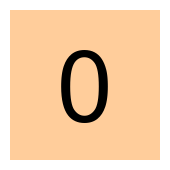

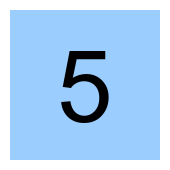

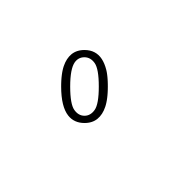

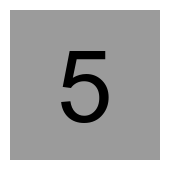

In [19]:
"""Load `numbers.npy`..."""
arr = np.load(Path.cwd() / "data" / "numbers.npy")
print(arr.shape)

# `numbers.npy` contains 6 RGB images of size 150x150, containing numbers 0-5. Some examples:
display_array_as_img(arr[0])  # RGB
display_array_as_img(arr[5])  # RGB
display_array_as_img(arr[0, 0])  # monochronme
display_array_as_img(arr[5, 0])  # monochronme

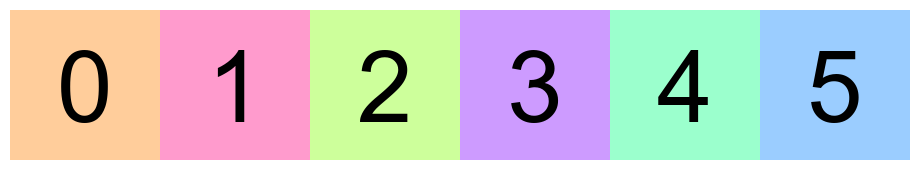

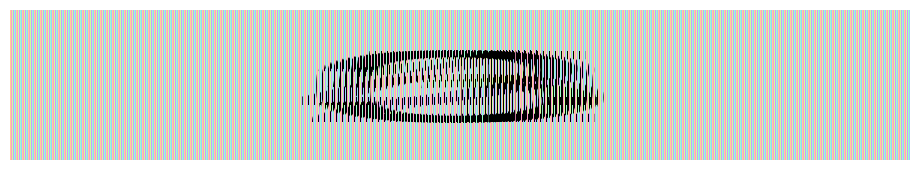

In [20]:
"""Exercise 1: display all 5 numbers together horizontally"""

# shape: 3, 150, 900
arr1 = rearrange(arr, "i c h w -> c h (i w)")
display_array_as_img(arr1) 

# Note how above is different to this:
# here we spread each image across the new width, while above we fit each image into the new width
arr1b = rearrange(arr, "i c h w -> c h (w i)")
display_array_as_img(arr1b)

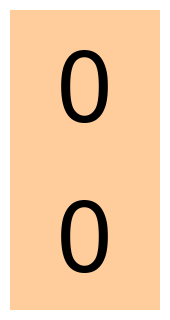

In [21]:
"""Exercise 2: display '0' concatenated with itself vertically"""

# shape: 3, 300, 150
arr2 = repeat(arr[0], "c h w -> c (2 h) w")
display_array_as_img(arr2)

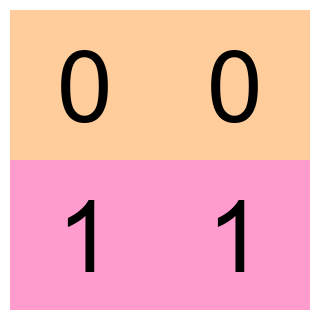

In [22]:
"""Exercise 3: display a 2x2 image of two '0's (top) and two '1's (bottom)"""

# shape: 3, 300, 300
arr3 = repeat(arr[0:2], "i c h w -> c (i h) (2 w)")
display_array_as_img(arr3)

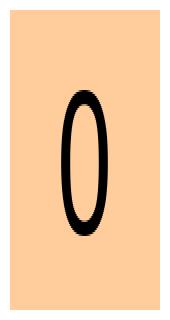

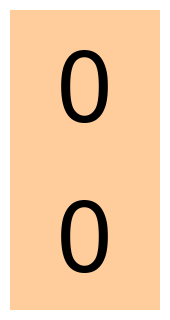

In [23]:
"""Exercise 4: elongate '0' by a factor of two along its height"""

# shape: 3, 300, 150
arr4 = repeat(arr[0], "c h w -> c (h 2) w")
display_array_as_img(arr4)

# Note how above is different to this:
# here we fit the image twice into the new height, above we spread the image across the new height
arr4 = repeat(arr[0], "c h w -> c (2 h) w")
display_array_as_img(arr4)

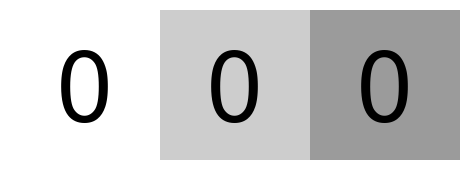

In [24]:
"""Exercise 5: view all three monochrome channels of '0' side-by-side"""

# shape: 450, 150
arr5 = rearrange(arr[0], "c h w -> h (c w)")
display_array_as_img(arr5)

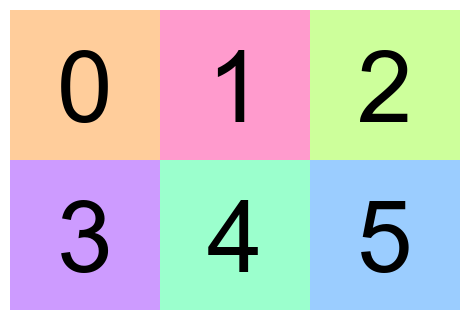

In [25]:
"""Exercise 6: view all six numbers in a 2x3 grid"""

# shape: 3, 300, 450
arr6 = rearrange(arr, "(hx wx) c h w -> c (hx h) (wx w)", hx=2, wx=3)
display_array_as_img(arr6)

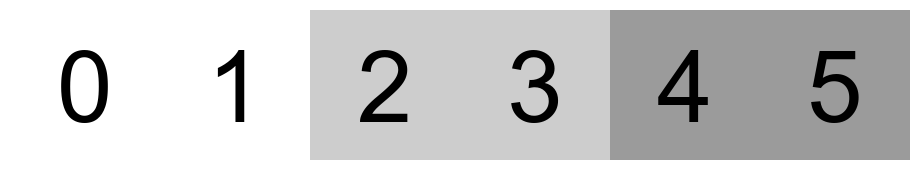

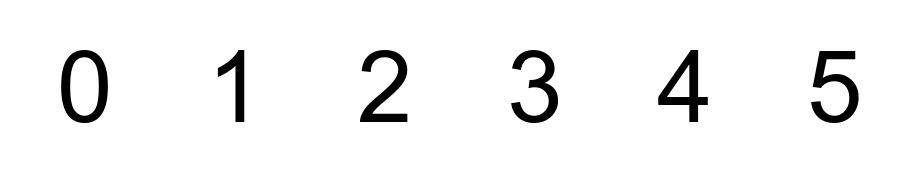

In [26]:
"""Exercise 7: view all six numbers in a 1x6 grid, in black-and-white"""

# shape: 150, 900
arr7 = rearrange(arr[:, 0, :, :], "i h w -> h (i w)")
display_array_as_img(arr7)

arr7b = reduce(arr, "i c h w -> h (i w)", "max")  # max over the c dim (white=255)
display_array_as_img(arr7b)

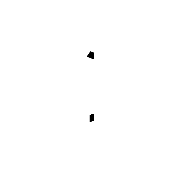

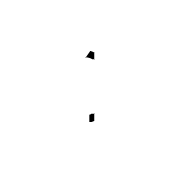

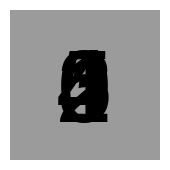

In [27]:
"""Exercise 8: view all 6 numbers in monochrome overlaid on top of each other"""

# shape: 150, 150
arr8b = reduce(arr, "i c h w -> h w", "sum")
display_array_as_img(arr8b)

arr8c = reduce(arr, "i c h w -> h w", "max")
display_array_as_img(arr8c)

# This one actually does what we want it to: otherwise if we sum or max, we saturate
arr8 = reduce(arr, "i c h w -> h w", "min")
display_array_as_img(arr8)

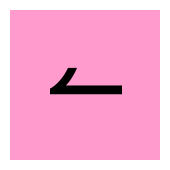

In [28]:
"""Exercise 9: flip 1 on its horizontal axis, and rotate it 90 degrees ccw"""

# shape: 3, 150, 150

arr9 = rearrange(arr[1], "c h w -> c w h")
display_array_as_img(arr9)

## ARENA Exercises: Creating functions that use einops

See exercises here: https://arena-chapter0-fundamentals.streamlit.app/[0.0]_Prerequisites#einops-exercises-operations

In [29]:
"""Exercise B.1 - temperature average"""

def temperatures_average(temps: torch.Tensor) -> torch.Tensor:
    """Return the average temperature for each week.

    temps: a 1D temperature containing temperatures for each day.
    Length will be a multiple of 7 and the first 7 days are for the first week, second 7 days for the second week, etc.

    You can do this with a single call to reduce.
    """
    assert len(temps) % 7 == 0
    # YOUR CODE HERE
    # reformat `temps` into Nx7 tensor, where N is number of weeks, then reduce over N
    temps = rearrange(temps, "(w d) -> w d", d=7)
    return reduce(temps, "w d -> w", "mean")
    # We could also have done:
    # return reduce(temps, "(w d) -> w", "mean", d=7)

temps = torch.Tensor(
    [71, 72, 70, 75, 71, 72, 70, 68, 65, 60, 68, 60, 55, 59, 75, 80, 85, 80, 78, 72, 83]
)
expected = torch.tensor([71.5714, 62.1429, 79.0])
print(temperatures_average(temps))

tensor([71.5714, 62.1429, 79.0000])


In [30]:
"""Exercise B.2 - temperature difference"""

def temperatures_differences(temps: torch.Tensor) -> torch.Tensor:
    """For each day, subtract the average for the week the day belongs to.

    temps: a 1D temperature containing temperatures for each day.
    """
    assert len(temps) % 7 == 0
    # YOUR CODE HERE
    week_avg_for_day = repeat(reduce(temps, "(w d) -> w", "mean", d=7), "w -> (w d)", d=7)
    return temps - week_avg_for_day

temps = torch.Tensor(
    [71, 72, 70, 75, 71, 72, 70, 68, 65, 60, 68, 60, 55, 59, 75, 80, 85, 80, 78, 72, 83]
)
expected = torch.tensor(
    [
        -0.5714,
        0.4286,
        -1.5714,
        3.4286,
        -0.5714,
        0.4286,
        -1.5714,
        5.8571,
        2.8571,
        -2.1429,
        5.8571,
        -2.1429,
        -7.1429,
        -3.1429,
        -4.0,
        1.0,
        6.0,
        1.0,
        -1.0,
        -7.0,
        4.0,
    ]
)
print(temperatures_differences(temps))


tensor([-0.5714,  0.4286, -1.5714,  3.4286, -0.5714,  0.4286, -1.5714,  5.8571,
         2.8571, -2.1429,  5.8571, -2.1429, -7.1429, -3.1429, -4.0000,  1.0000,
         6.0000,  1.0000, -1.0000, -7.0000,  4.0000])


In [31]:
"""Exercise B.3 - temperature normalized"""

def temperatures_normalized(temps: torch.Tensor) -> torch.Tensor:
    """For each day, subtract the weekly average and divide by the weekly standard deviation.

    temps: a 1D temperature containing temperatures for each day.

    Pass torch.std to reduce.
    """
    # YOUR CODE HERE
    week_std_for_day = repeat(reduce(temps, "(w d) -> w", torch.std, d=7), "w -> (w d)", d=7)
    return temperatures_differences(temps) / week_std_for_day


expected = torch.tensor(
    [
        -0.3326,
        0.2494,
        -0.9146,
        1.9954,
        -0.3326,
        0.2494,
        -0.9146,
        1.1839,
        0.5775,
        -0.4331,
        1.1839,
        -0.4331,
        -1.4438,
        -0.6353,
        -0.8944,
        0.2236,
        1.3416,
        0.2236,
        -0.2236,
        -1.5652,
        0.8944,
    ]
)
print(temperatures_normalized(temps))


tensor([-0.3326,  0.2494, -0.9146,  1.9954, -0.3326,  0.2494, -0.9146,  1.1839,
         0.5775, -0.4331,  1.1839, -0.4331, -1.4438, -0.6353, -0.8944,  0.2236,
         1.3416,  0.2236, -0.2236, -1.5652,  0.8944])


In [32]:
"""Exercise C - identity matrix"""

def identity_matrix(n: int) -> torch.Tensor:
    """
    Return the identity matrix of size n x n using einops,
    without using torch.arange or torch.eye.
    """
    assert n >= 0
    # YOUR CODE HERE
    # Use cumsum to generate indices we want, create a row and a col vector from these indices,
    # and compare them, allowing broadcasting to fill-in with 0s the missing cols in the 
    # col vector and the missing rows in the row vector
    idx_1d = torch.cumsum(torch.ones(n), dim=0)  # shape: [n]
    row_idx = rearrange(idx_1d, 'i -> i 1')      # shape: [n, 1]
    col_idx = rearrange(idx_1d, 'j -> 1 j')      # shape: [1, n]
    return (row_idx == col_idx).int()


display(identity_matrix(3), identity_matrix(4))

tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]], dtype=torch.int32)

tensor([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]], dtype=torch.int32)

In [33]:
"""Exercise H.1 - batched logsumexp"""

def batched_logsumexp(matrix: torch.Tensor) -> torch.Tensor:
    """For each row of the matrix, compute log(sum(exp(row))) in a numerically stable way.

    matrix: shape (batch, n)

    Return: (batch, ). For each i, out[i] = log(sum(exp(matrix[i]))).

    Do this without using PyTorch's logsumexp function.

    A couple useful blogs about this function:
    - https://leimao.github.io/blog/LogSumExp/
    - https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    """
    # Formula: x_max + log(sum(exp(x - x_max)))
    rows_max = reduce(matrix, "b n -> b", "max")
    exps = torch.exp(matrix - rearrange(rows_max, "b -> b 1"))
    logsumexp = rows_max + torch.log(reduce(exps, "b n -> b", "sum"))
    return logsumexp

matrix = torch.tensor([[-1000, -1000, -1000, -1000], [1000, 1000, 1000, 1000]])
expected = torch.tensor([-1000 + math.log(4), 1000 + math.log(4)])
actual = batched_logsumexp(matrix)
display(expected, actual)

matrix2 = torch.randn((10, 20))
expected2 = torch.logsumexp(matrix2, dim=-1)
actual2 = batched_logsumexp(matrix2)
display(expected2, actual2)

tensor([-998.6137, 1001.3863])

tensor([-998.6137, 1001.3863])

tensor([3.7315, 3.3176, 3.2114, 3.2743, 3.5250, 3.2677, 3.5614, 3.4259, 3.2843,
        3.6279])

tensor([3.7315, 3.3176, 3.2114, 3.2743, 3.5250, 3.2677, 3.5614, 3.4259, 3.2843,
        3.6279])

In [34]:
"""Exercise H.2 - batched softmax"""

def batched_softmax(matrix: torch.Tensor) -> torch.Tensor:
    """For each row of the matrix, compute softmax(row).

    Do this without using PyTorch's softmax function.
    Instead, use the definition of softmax: https://en.wikipedia.org/wiki/Softmax_function

    matrix: shape (batch, n)

    Return: (batch, n). For each i, out[i] should sum to 1.
    """
    # Formula: e^x_i / sum(e^x)
    return matrix.exp() / rearrange(reduce(matrix.exp(), "b n -> b", "sum"), "b -> b 1")


matrix = torch.arange(1, 6).view((1, 5)).float().log()
expected = torch.arange(1, 6).view((1, 5)) / 15.0
actual = batched_softmax(matrix)
display(expected, actual)

matrix2 = torch.rand((10, 20))
actual2 = batched_softmax(matrix2)
assert actual2.min() >= 0.0
assert actual2.max() <= 1.0

tensor([[0.0667, 0.1333, 0.2000, 0.2667, 0.3333]])

tensor([[0.0667, 0.1333, 0.2000, 0.2667, 0.3333]])

In [35]:
"""Exercise H.3 - batched logsoftmax"""

def batched_logsoftmax(matrix: torch.Tensor) -> torch.Tensor:
    """Compute log(softmax(row)) for each row of the matrix.

    matrix: shape (batch, n)

    Return: (batch, n). For each i, exp(out[i]) should sum to 1.

    Do this without using PyTorch's logsoftmax function.
    For each row, subtract the maximum first to avoid overflow if the row contains large values.
    """
    # Formula: (x_i - (x_max + log(sum(e^(x - x_max)))
    rows_max = reduce(matrix, "b n -> b", "max")
    diff_rows_max = matrix - rearrange(rows_max, "b -> b 1")
    logsumdiff = torch.log(reduce(diff_rows_max.exp(), "b n -> b", "sum"))
    return diff_rows_max - rearrange(logsumdiff, "b -> b 1")

start = 1000
matrix = torch.arange(start + 1, start + 6).view((1, 5)).float()
actual = batched_logsoftmax(matrix)
expected = torch.tensor([[-4.4519, -3.4519, -2.4519, -1.4519, -0.4519]])
display(expected, actual)

tensor([[-4.4519, -3.4519, -2.4519, -1.4519, -0.4519]])

tensor([[-4.4519, -3.4519, -2.4519, -1.4519, -0.4519]])

In [36]:
"""Exercise H.4 - batched cross-entropy loss"""


def batched_cross_entropy_loss(logits: torch.Tensor, true_labels: torch.Tensor) -> torch.Tensor:
    """Compute the cross entropy loss for each example in the batch.

    logits: shape (batch, classes). logits[i][j] the raw prediction for example i and class j.
    true_labels: shape (batch, ). true_labels[i] an integer index of the true class for example i.

    Return: shape (batch, ). out[i] is the loss for example i.

    Hint: convert the logits to log-probabilities using your batched_logsoftmax from above.
    Then the loss for an example is just the negative of the log-probability that the model 
    assigned to the true class. Use torch.gather to perform the indexing.
    """
    # Formula (for a single example, where we sum over classes):
    # -sum(log(softmax(logits) * true_labels))
    assert logits.shape[0] == true_labels.shape[0]
    assert true_labels.max() < logits.shape[1]

    logprobs = batched_logsoftmax(logits)
    # Gather the logprobs only for the true label for each example
    # (other logprobs sum to 0 for each example).
    pred_for_true = -logprobs.gather(1, rearrange(true_labels, "n -> n 1"))
    return rearrange(pred_for_true, "n 1 -> n")


logits = torch.tensor(
    [[float("-inf"), float("-inf"), 0], [1 / 3, 1 / 3, 1 / 3], [float("-inf"), 0, 0]]
)
true_labels = torch.tensor([2, 0, 0])
expected = torch.tensor([0.0, math.log(3), float("inf")])
actual = batched_cross_entropy_loss(logits, true_labels)
display(expected, actual)

tensor([0.0000, 1.0986,    inf])

tensor([-0.0000, 1.0986,    inf])

## Additional einops patterns & ops (`including asnumpy`, `parse_shape`, `pack`, and `unpack`)

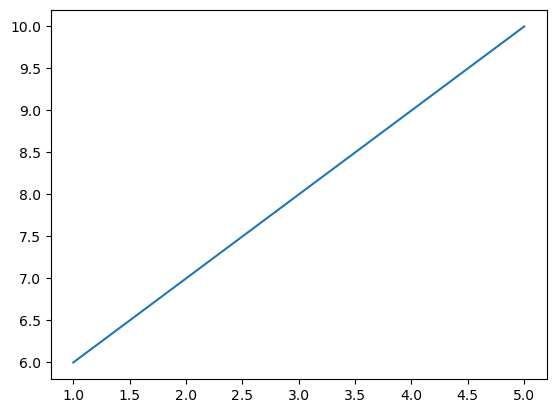

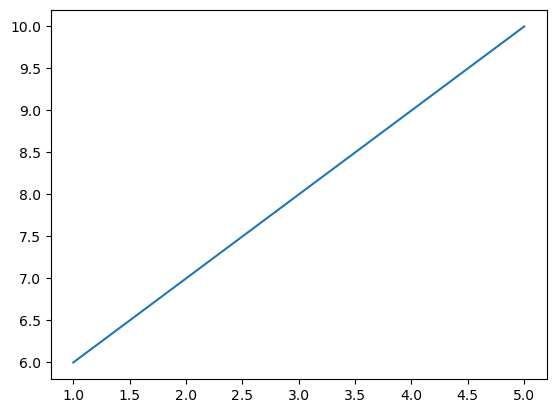

In [37]:
"""`asnumpy` allows conversion to np array with implicit detach and move to cpu"""

xy = torch.arange(1, 11, requires_grad=True, dtype=float).view(2, 5).to(device)

# Plot row 2 over row 1 (explicitly detach grad, move to cpu, convert to numpy)
fig, ax = plt.subplots()
ax.plot(xy[0].detach().cpu().numpy(), xy[1].detach().cpu().numpy())

# Plot row 2 over row 1 (let `asnumpy` handle everything)
fig, ax = plt.subplots()
ax.plot(*asnumpy(xy))

In [38]:
"""`parse_shape` allows for easy shape interpretation"""

# Imagine we are working with 3d image date (x, y, z) + channel + batch dimensions,
# and we want to perform "same"-size window-avg 2d convolution over the x and y dimensions.

x_5d = torch.randn(32, 3, 224, 224, 224).to(device)
print(parse_shape(x_5d, "b c x y z"))

# Perform 2d convolution
kernel_sz = 9
out_ch, in_ch = x_5d.shape[1], x_5d.shape[1]
kernel = torch.ones(out_ch, in_ch, kernel_sz, kernel_sz).to(device) / kernel_sz
padding = kernel_sz // 2  # "same"-size conv by default
x_for_conv2d = rearrange(x_5d, "b c x y z -> (b z) c x y")
y = F.conv2d(x_for_conv2d, kernel, padding=padding, stride=1, dilation=1, groups=1)

# Reform the 5d tensor, verifying shape with `**parse_shape`
y = rearrange(y, "(b z) c x y -> b c x y z", **parse_shape(x_5d, "b c x y z"))

# We can also only output size of dims we care about (use `_` for dims we don't care about)
print(parse_shape(y, "b c x _ _"))

{'b': 32, 'c': 3, 'x': 224, 'y': 224, 'z': 224}
{'b': 32, 'c': 3, 'x': 224}


In [39]:
"""`pack` and `unpack`"""

# Imagine we have a set of rgb images, and we want to stack on top of a grayscale image
# 'n' is for concurrent number of model instances to feed to (we can think of this as a
# meta-batch dimension), and we want to pack together all channels (treat each's value as a 
# grayscale value) of all batches of all model instances together into a single batch dim.

n, b, c, h, w = 2, 32, 3, 100, 200
images = np.random.random([n, b, c, h, w])
new_image = np.random.random([h, w])

# Pack along the channel dimension
image_rgbd, ps = pack([images, new_image], "* h w")
print("Pack:")
print(f"{image_rgbd.shape=}\n{ps=}")

# Unpack along the channel dimension
print("\nUnpack:")
image_rgb2, image_depth2 = unpack(image_rgbd, ps, "* h w")
print(f"{image_rgb2.shape=}\n{image_depth2.shape=}")

Pack:
image_rgbd.shape=(193, 100, 200)
ps=[(2, 32, 3), ()]

Unpack:
image_rgb2.shape=(2, 32, 3, 100, 200)
image_depth2.shape=(100, 200)


In [46]:
"""`pack` and `unpack` continued"""

# Auto-batching: ML models by default accept batches: batches of images, batches of text,
# batches of audio, etc.
#
# During debugging or inference, however, it is common to pass a single example instead of a full
# batch (and thus output should be a single prediction)
#
# We can write a `universal_predict` function with `pack` and `unpack` that can handle both cases.

c, h, w = 3, 224, 224

def image_classifier(images_bhwc):
    # mock for image classifier: let's just average the pixels for each channel
    predictions = reduce(images_bhwc, "b h w c -> b c", "mean", h=h, w=w, c=c)
    return predictions


def universal_predict(x):
    x_packed, ps = pack([x], "* h w c")
    predictions_packed = image_classifier(x_packed)
    [predictions] = unpack(predictions_packed, ps, "* cls")
    return predictions

# works with a single image
print(universal_predict(np.zeros([h, w, c])).shape)
# works with a batch of images
batch = 5
print(universal_predict(np.zeros([batch, h, w, c])).shape)
# or even a batch of videos
n_frames = 7
print(universal_predict(np.zeros([batch, n_frames, h, w, c])).shape)

(3,)
(5, 3)
(5, 7, 3)


In [40]:
"""einops layers to use with pytorch module models"""

# Example of a simple CNN model using einops layers
b, c, w, h = 32, 3, 224, 224
conv_kernel_sz = 9
pool_kernel_sz = 2
first_conv_out_ch = 8
second_conv_out_ch = 16
final_linear_sz = 100
n_classes = 10
final_w = (((w - conv_kernel_sz + 1) // pool_kernel_sz) - conv_kernel_sz + 1) // pool_kernel_sz
final_h = (((h - conv_kernel_sz + 1) // pool_kernel_sz) - conv_kernel_sz + 1) // pool_kernel_sz
model = nn.Sequential(
    Rearrange("b c w h -> b c h w"),
    nn.Conv2d(c, first_conv_out_ch, kernel_size=conv_kernel_sz),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(first_conv_out_ch, second_conv_out_ch, kernel_size=conv_kernel_sz),
    # combine pool and flatten in a single step
    Reduce("b c (h h_pool_sz) (w w_pool_sz) -> b (c h w)", "max", h_pool_sz=2, w_pool_sz=2),
    nn.Linear(second_conv_out_ch * final_w * final_h, final_linear_sz),
    nn.ReLU(),
    nn.Linear(final_linear_sz, n_classes)
)

## Indexing via advanced indexing and `gather`

In [41]:
"""Advanced indexing of a 3d tensor."""

t_3d = torch.arange(2 * 3 * 4).view((2, 3, 4))
coords_3d = torch.tensor([[0, 0, 0], [0, 1, 1], [0, 2, 2], [1, 0, 3], [1, 2, 0]])

# Return each element specified by the three coordinates in the first dim of `coords_3d`
display(t_3d[tuple(coords_3d.T)])

# Return all elements in the 3rd dim of `t_3d` specified by the first two dims of `coords_3d`
display(t_3d[tuple(coords_3d.T)[0:2]])

tensor([ 0,  5, 10, 15, 20])

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [20, 21, 22, 23]])

In [42]:
"""`gather` various values along the different dimensions of a 2-d and 3-d tensor"""

# Index-tensor's first dim must match input-tensor's first dim

t_2d = torch.arange(15).view(3, 5)
display(t_2d)

# View d0-0,d1-4; d0-1,d1-3; d0-2,d1-2
indexes = torch.tensor([[4], [3], [2]])
display(t_2d.gather(1, indexes))

# View [row0-ele2, row0-ele4], [row1-ele1, row1-ele3], and [row2-ele0, row2-ele2]
# View [d0-0,d1-2; d0-0,d1-4]; [d0-1,d1-1; d0-1,d1-3]; [d0-2,d1-0; d0-2,d1-2]
# Specify indices along dim1 for each dim0
indexes2 = torch.tensor([[2, 4], [1, 3], [0, 2]])
display(t_2d.gather(1, indexes2))

t_3d = torch.arange(2 * 3 * 4).view((2, 3, 4))
display(t_3d)

# View [d0-0,d1-0,d2-0; d0-0,d1-1,d2-0; d0-0,d1-0,d2-2];
#      [d0-1,d1-1,d2-0; d0-1,d1-1,d2-1; d0-1,d1-1,d2-2]
# Specify indices along dim2 for each dim0,dim1
indexes3d = torch.tensor(
    [
        [[0], [0], [0]],  # For d0=0, each row picks index=0 along dim=2
        [[1], [1], [1]],  # For d0=1, each row picks index=1 along dim=2
    ]
)
display(t_3d.gather(2, indexes3d))

tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14]])

tensor([[ 4],
        [ 8],
        [12]])

tensor([[ 2,  4],
        [ 6,  8],
        [10, 12]])

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]],

        [[12, 13, 14, 15],
         [16, 17, 18, 19],
         [20, 21, 22, 23]]])

tensor([[[ 0],
         [ 4],
         [ 8]],

        [[13],
         [17],
         [21]]])